# 1. Install and Import Dependencies

In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizerFast, AutoConfig
import torch
import requests
import re
from scipy.special import softmax
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import nltk
from nltk.corpus import stopwords
from collections import Counter
from tqdm import trange
import os
from sklearn.feature_extraction.text import CountVectorizer

## New Model

In [2]:
# def preprocess(text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# #model.save_pretrained(MODEL)
# text = preprocess(text)
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)
# scores

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def predict(text):
    sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length=512, truncation=True)
    out = sentiment_task(text)
    return out[0]['label']

In [4]:
predict("ok")

'neutral'

# 5. Load Reviews into DataFrame and Score

In [5]:
import numpy as np
import pandas as pd

In [6]:
def review_rating_split(rev_string):
    return rev_string.split()[1]

In [7]:
def year_split(dte):
    return dte.split()[2]

In [8]:
# Define a custom function to fill NaN values in Column1
def fill_reviewtext_nan(row):
    if pd.isna(row['review_text']):
        return row['review_title']
    else:
        return row['review_text']

In [9]:
# df = pd.read_csv("wineaccess.csv", sep='\t')

directory_path = 'scrapped_CSVs'

# Initialize an empty list to store DataFrames from each CSV file
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Read each CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path, sep='\t', lineterminator='\n')
        dataframes.append(df)

# Concatenate all DataFrames in the list into one
df_all = pd.concat(dataframes, ignore_index=True)
df_all['review_text'] = df_all.apply(fill_reviewtext_nan, axis=1)

In [10]:
df_all

,site,location,review_title,review_date_original,review_rating,review_text
0,firstleaf,US,This is obviously a money grab/scam,11 September 2023,Rated 1 out of 5 stars,This is obviously a money grab/scam. Horrible ...
1,firstleaf,US,Absolute garbage,27 August 2023,Rated 1 out of 5 stars,"Absolute garbage, cancelled repeatedly online ..."
2,firstleaf,US,I very much enjoy this wine…,25 June 2023,Rated 5 out of 5 stars,"I very much enjoy this wine subscription, they..."
3,firstleaf,US,First Leaf: Wines are tailored to your ratings…,21 June 2023,Rated 5 out of 5 stars,Wines are tailored to your ratings which is tr...
4,firstleaf,US,Excellent wines,30 April 2023,Rated 5 out of 5 stars,Excellent wines. Great service. Curated for ...
...,...,...,...,...,...,...
13900,winedirect,IE,No delivery of £100 order and no …,06 April 2017,Rated 1 out of 5 stars,No delivery of £100 order and no response to p...
13901,winedirect,GB,Phew - the order did eventually arrive!,22 December 2016,Rated 2 out of 5 stars,"The champagne I ordered did arrive, but unless..."
13902,winedirect,PL,DO NOT DO BUSINESS WITH THIS COMPANY,02 December 2016,Rated 1 out of 5 stars,I ordered almost £500 worth of wine from this ...
13903,winedirect,GB,Went above and beyond,15 October 2016,Rated 5 out of 5 stars,I ordered a case of the wine we drank at our w...


In [11]:
df = df_all[df_all['location'].str.contains('US', case=False)]

In [13]:
df = df.reset_index()
df

,index,site,location,review_title,review_date_original,review_rating,review_text
0,0,firstleaf,US,This is obviously a money grab/scam,11 September 2023,Rated 1 out of 5 stars,This is obviously a money grab/scam. Horrible ...
1,1,firstleaf,US,Absolute garbage,27 August 2023,Rated 1 out of 5 stars,"Absolute garbage, cancelled repeatedly online ..."
2,2,firstleaf,US,I very much enjoy this wine…,25 June 2023,Rated 5 out of 5 stars,"I very much enjoy this wine subscription, they..."
3,3,firstleaf,US,First Leaf: Wines are tailored to your ratings…,21 June 2023,Rated 5 out of 5 stars,Wines are tailored to your ratings which is tr...
4,4,firstleaf,US,Excellent wines,30 April 2023,Rated 5 out of 5 stars,Excellent wines. Great service. Curated for ...
...,...,...,...,...,...,...,...
5487,13790,winedirect,US,I ordered the wine just going by …,31 December 2017,Rated 5 out of 5 stars,"I ordered the wine just going by instinct, a C..."
5488,13819,winedirect,US,Ordered wine for my Mum's Christmas …,20 December 2017,Rated 1 out of 5 stars,Ordered wine for my Mum's Christmas gift from ...
5489,13822,winedirect,US,The worst customer service ever!,20 December 2017,Rated 1 out of 5 stars,The worst customer service ever!This is undoub...
5490,13856,winedirect,US,Best UK wine shipping company,13 December 2017,Rated 5 out of 5 stars,"Easy website., quick turnaround, just the plac..."


In [14]:
df.to_csv("a.csv")

In [15]:
df["review_title"]

0                   This is obviously a money grab/scam
1                                      Absolute garbage
2                          I very much enjoy this wine…
3       First Leaf: Wines are tailored to your ratings…
4                                       Excellent wines
                             ...                       
5487                 I ordered the wine just going by …
5488              Ordered wine for my Mum's Christmas …
5489                   The worst customer service ever!
5490                      Best UK wine shipping company
5491                                          Very poor
Name: review_title, Length: 5492, dtype: object

In [16]:
df["review_rating"] = df["review_rating"].apply(review_rating_split)
df["review_date_original"] = df["review_date_original"].apply(year_split)

In [17]:
df

,index,site,location,review_title,review_date_original,review_rating,review_text
0,0,firstleaf,US,This is obviously a money grab/scam,2023,1,This is obviously a money grab/scam. Horrible ...
1,1,firstleaf,US,Absolute garbage,2023,1,"Absolute garbage, cancelled repeatedly online ..."
2,2,firstleaf,US,I very much enjoy this wine…,2023,5,"I very much enjoy this wine subscription, they..."
3,3,firstleaf,US,First Leaf: Wines are tailored to your ratings…,2023,5,Wines are tailored to your ratings which is tr...
4,4,firstleaf,US,Excellent wines,2023,5,Excellent wines. Great service. Curated for ...
...,...,...,...,...,...,...,...
5487,13790,winedirect,US,I ordered the wine just going by …,2017,5,"I ordered the wine just going by instinct, a C..."
5488,13819,winedirect,US,Ordered wine for my Mum's Christmas …,2017,1,Ordered wine for my Mum's Christmas gift from ...
5489,13822,winedirect,US,The worst customer service ever!,2017,1,The worst customer service ever!This is undoub...
5490,13856,winedirect,US,Best UK wine shipping company,2017,5,"Easy website., quick turnaround, just the plac..."


In [18]:
df["review_sentiment"] = df['review_text'].apply(predict)
df["review_title_sentiment"] = df['review_title'].apply(predict)

In [19]:
df.describe()

,index
count,5492.000000
mean,8065.689366
std,4430.983348
min,0.000000
25%,7621.750000
50%,9450.000000
75%,11702.250000
max,13870.000000


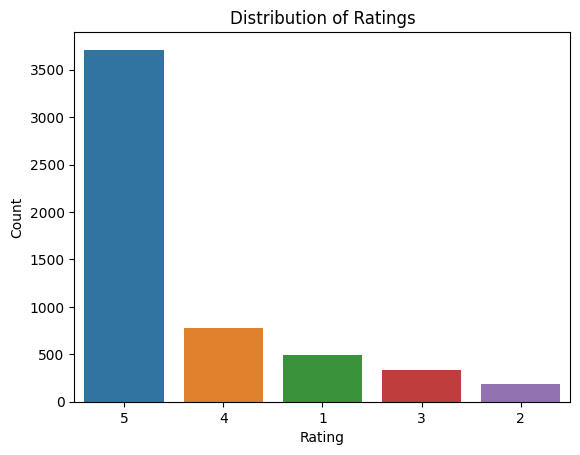

In [20]:
# Visualize the distribution of ratings:
sns.countplot(x='review_rating', data=df, order = df['review_rating'].value_counts().index)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

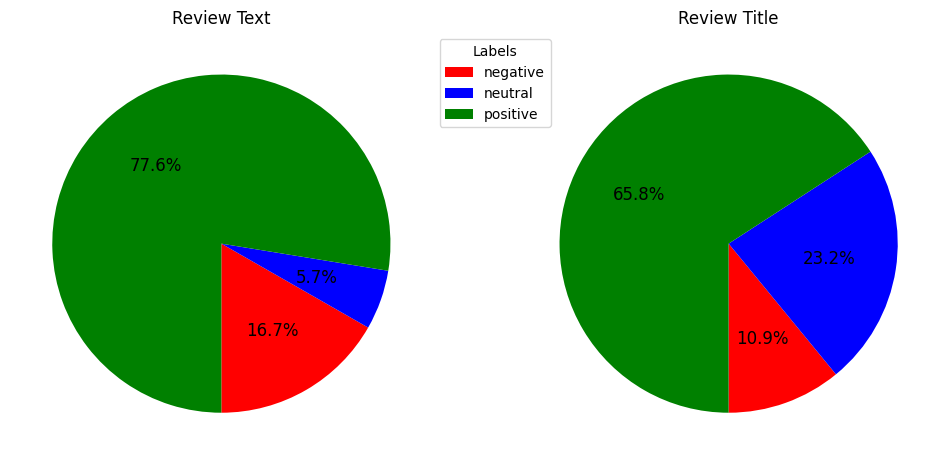

In [21]:
import matplotlib.pyplot as plt

# Sample data for the pie charts
sentiment_counts = df.groupby(['review_sentiment']).size()

# Define distinct colors for each label
colors = ['red', 'blue', 'green']

# Create a 1x2 grid of subplots for two pie charts side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Plot the first pie chart in the first subplot (ax1)
sentiment_counts.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None, colors=colors)
ax1.set_ylabel('')  # Remove the y-label for cleaner presentation
ax1.set_title('Review Text')

# You can create a second DataFrame or modify the existing one for the second pie chart
sentiment_counts_2 = df.groupby(['review_title_sentiment']).size()  # Sample data for the second pie chart

# Plot the second pie chart in the second subplot (ax2)
sentiment_counts_2.plot.pie(ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None, colors=colors)
ax2.set_ylabel('')  # Remove the y-label for cleaner presentation
ax2.set_title('Review Title')

# Create a legend to show label colors
labels = sentiment_counts.index
ax1.legend(labels, loc='best', title="Labels", bbox_to_anchor=(1, 1))

# Adjust spacing between subplots if needed
# plt.tight_layout()

# Display the plot
plt.show()


Text(0.5, 0.98, 'Histogram number of words in reviews and reviews title')

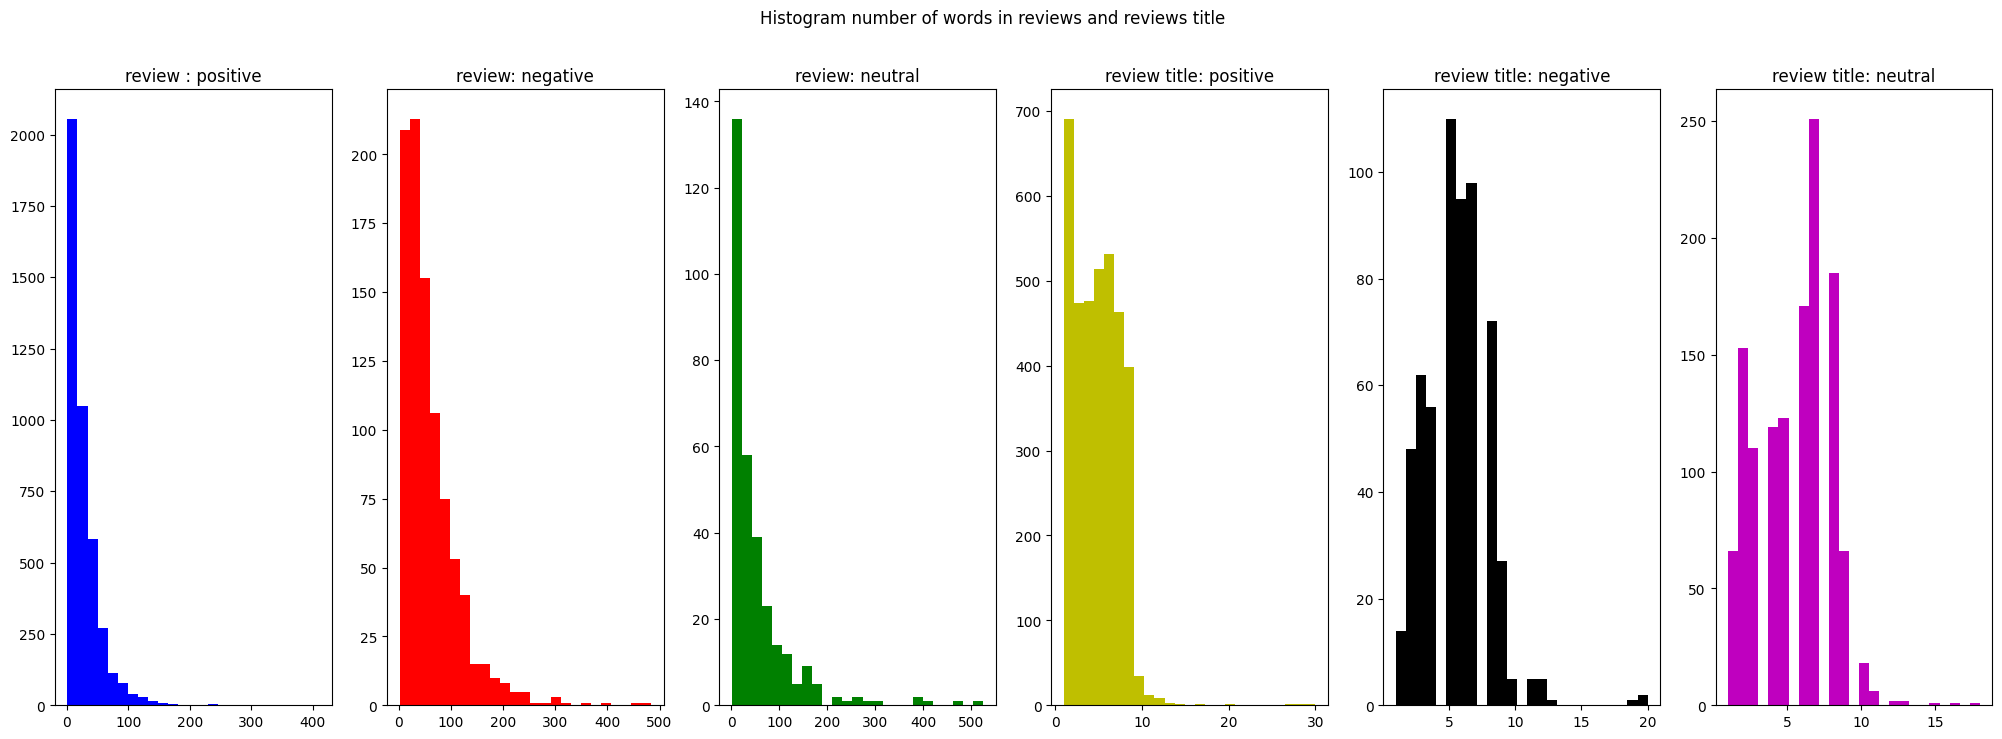

In [22]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(25,8))

ax1.hist(df[df['review_sentiment'] == "positive"]['review_text'].str.split().map(lambda x: len(x)), bins=25, color='b')
ax1.set_title('review : positive')

ax2.hist(df[df['review_sentiment'] == "negative"]['review_text'].str.split().map(lambda x: len(x)), bins=25, color='r')
ax2.set_title('review: negative')

ax3.hist(df[df['review_sentiment'] == "neutral"]['review_text'].str.split().map(lambda x: len(x)), bins=25, color='g')
ax3.set_title('review: neutral')

ax4.hist(df[df['review_title_sentiment'] == "positive"]['review_title'].str.split().map(lambda x: len(x)), bins=25, color='y')
ax4.set_title('review title: positive')

ax5.hist(df[df['review_title_sentiment'] == "negative"]['review_title'].str.split().map(lambda x: len(x)), bins=25, color='k')
ax5.set_title('review title: negative')

ax6.hist(df[df['review_title_sentiment'] == "neutral"]['review_title'].str.split().map(lambda x: len(x)), bins=25, color='m')
ax6.set_title('review title: neutral')

f.suptitle('Histogram number of words in reviews and reviews title')

In [40]:
df.head()

,index,site,location,review_title,review_date_original,review_rating,review_text,review_sentiment,review_title_sentiment,review_text_list
0,0,firstleaf,US,This is obviously a money grab/scam,2023,1,obviously money grabscam horrible customer ser...,negative,negative,"[obviously, money, grabscam, horrible, custome..."
1,1,firstleaf,US,Absolute garbage,2023,1,absolute garbage cancelled repeatedly online s...,negative,negative,"[absolute, garbage, cancelled, repeatedly, onl..."
2,2,firstleaf,US,I very much enjoy this wine…,2023,5,much enjoy wine subscription dont send couple ...,positive,positive,"[much, enjoy, wine, subscription, dont, send, ..."
3,3,firstleaf,US,First Leaf: Wines are tailored to your ratings…,2023,5,wines tailored ratings true 5 mos 98 great win...,positive,neutral,"[wines, tailored, ratings, true, 5, mos, 98, g..."
4,4,firstleaf,US,Excellent wines,2023,5,excellent wines great service curated swap win...,positive,positive,"[excellent, wines, great, service, curated, sw..."


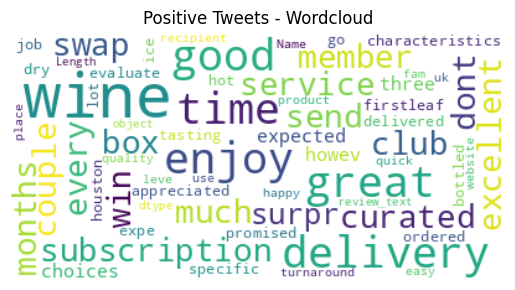

In [41]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
# Wordcloud with positive tweets
positive_tweets = df['review_text'][df["review_title_sentiment"] == 'positive']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 


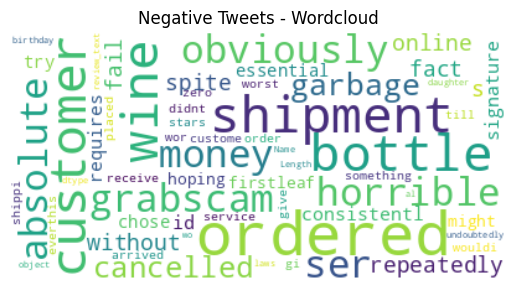

In [42]:
# Wordcloud with negative tweets
negative_tweets = df['review_text'][df["review_title_sentiment"] == 'negative']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

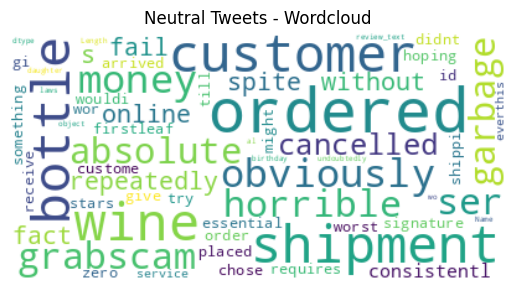

In [52]:
# Wordcloud with negative tweets
neutral_tweets = df['review_text'][df["review_title_sentiment"] == 'neutral']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
neutral_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.figure()
plt.title("Neutral Tweets - Wordcloud")
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [24]:
df['review_text'] = df['review_text'].apply(clean)

In [25]:
def corpus(text):
    text_list = text.split()
    return text_list

In [26]:
df['review_text_list'] = df['review_text'].apply(corpus)

In [28]:
df.shape[0]

5492

In [47]:
positive_corpus = []
negative_corpus = []
neutral_corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    if df['review_sentiment'][i]  == "positive":
        positive_corpus += df['review_text_list'][i]
    elif df['review_sentiment'][i]  == "negative":
        negative_corpus += df['review_text_list'][i]
    else:
        neutral_corpus += df['review_text_list'][i]
# len(positive_corpus), len(negative_corpus), len(neutral_corpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5492/5492 [00:00<00:00, 132891.33it/s]


In [49]:
mostCommon_positive = Counter(positive_corpus).most_common(10)
mostCommon_negative = Counter(negative_corpus).most_common(10)
mostCommon_neutral = Counter(neutral_corpus).most_common(10)
# mostCommon_positive, mostCommon_negative, mostCommon_neutral

In [50]:
words_pos = []
freq_pos = []
for word, count in mostCommon_positive:
    words_pos.append(word)
    freq_pos.append(count)

words_neg = []
freq_neg = []
for word, count in mostCommon_negative:
    words_neg.append(word)
    freq_neg.append(count)

words_neu = []
freq_neu = []
for word, count in mostCommon_neutral:
    words_neu.append(word)
    freq_neu.append(count)

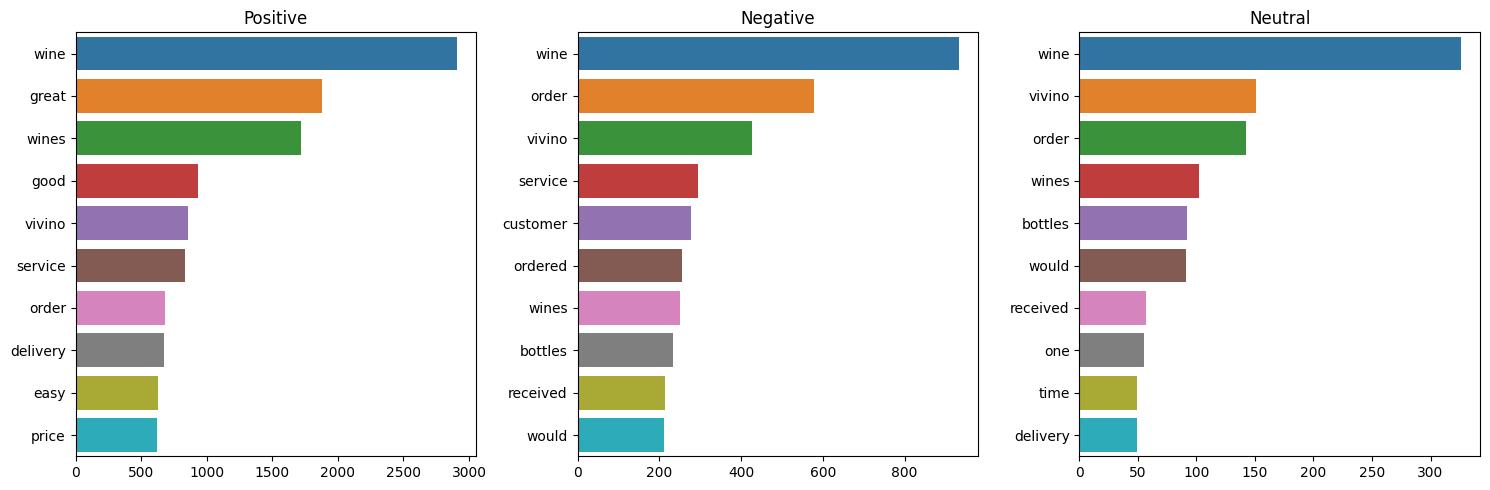

In [51]:
# Create a 1x3 grid of subplots for three bar plots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first bar plot in the first subplot (axes[0])
sns.barplot(x=freq_pos, y=words_pos, ax=axes[0])
axes[0].set_title('Positive')

# Plot the second bar plot in the second subplot (axes[1])
sns.barplot(x=freq_neg, y=words_neg, ax=axes[1])
axes[1].set_title('Negative')

# Plot the third bar plot in the third subplot (axes[2])
sns.barplot(x=freq_neu, y=words_neu, ax=axes[2])
axes[2].set_title('Neutral')

# Adjust spacing between subplots if needed
plt.tight_layout()

# Display the plot
plt.show()

In [60]:
cv_pos = CountVectorizer(ngram_range=(2,2))
cv_neg = CountVectorizer(ngram_range=(2,2))
cv_neu = CountVectorizer(ngram_range=(2,2))
bigrams_positive = cv_pos.fit_transform(df['review_text'][df["review_title_sentiment"] == 'positive'])
bigrams_negative = cv_neg.fit_transform(df['review_text'][df["review_title_sentiment"] == 'negative'])
bigrams_neutral = cv_neu.fit_transform(df['review_text'][df["review_title_sentiment"] == 'neutral'])

count_values_pos = bigrams_positive.toarray().sum(axis=0)
ngram_freq_pos = pd.DataFrame(sorted([(count_values_pos[i], k) for k, i in cv_pos.vocabulary_.items()], reverse = True))
ngram_freq_pos.columns = ["frequency", "ngram"]

count_values_neg = bigrams_negative.toarray().sum(axis=0)
ngram_freq_neg = pd.DataFrame(sorted([(count_values_neg[i], k) for k, i in cv_neg.vocabulary_.items()], reverse = True))
ngram_freq_neg.columns = ["frequency", "ngram"]

count_values_neu = bigrams_neutral.toarray().sum(axis=0)
ngram_freq_neu = pd.DataFrame(sorted([(count_values_neu[i], k) for k, i in cv_neu.vocabulary_.items()], reverse = True))
ngram_freq_neu.columns = ["frequency", "ngram"]

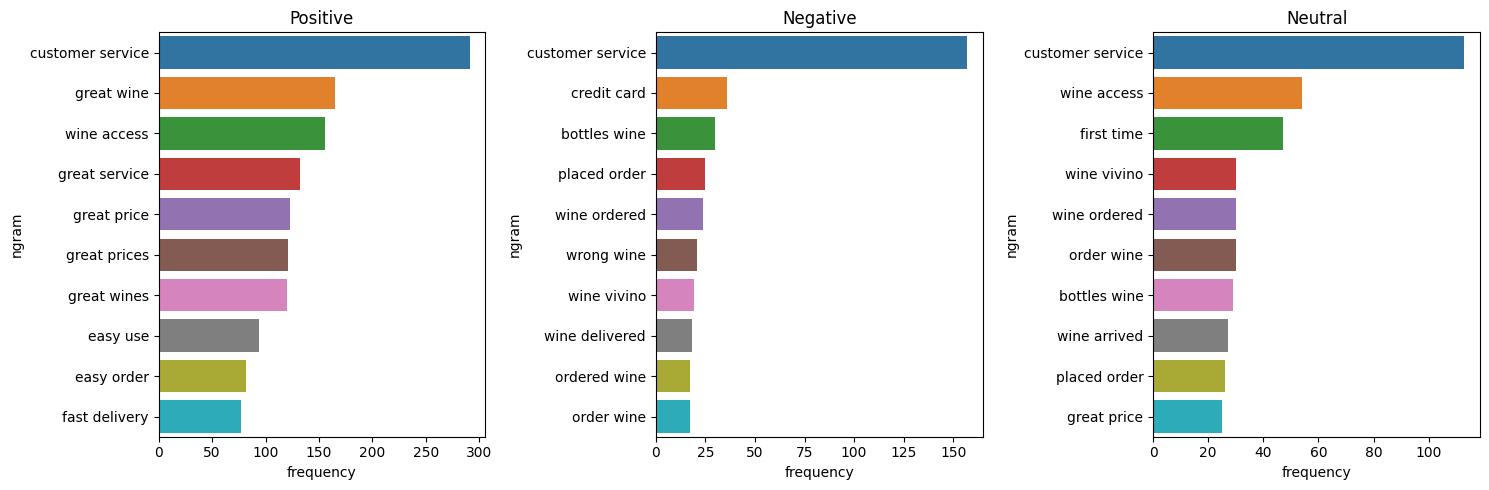

In [61]:
# Create a 1x3 grid of subplots for three bar plots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first bar plot in the first subplot (axes[0])
sns.barplot(x=ngram_freq_pos['frequency'][:10], y=ngram_freq_pos['ngram'][:10], ax=axes[0])
axes[0].set_title('Positive')

# Plot the second bar plot in the second subplot (axes[1])
sns.barplot(x=ngram_freq_neg['frequency'][:10], y=ngram_freq_neg['ngram'][:10], ax=axes[1])
axes[1].set_title('Negative')

# Plot the third bar plot in the third subplot (axes[2])
sns.barplot(x=ngram_freq_neu['frequency'][:10], y=ngram_freq_neu['ngram'][:10], ax=axes[2])
axes[2].set_title('Neutral')

# Adjust spacing between subplots if needed
plt.tight_layout()

# Display the plot
plt.show()

In [62]:
cv_pos = CountVectorizer(ngram_range=(3,3))
cv_neg = CountVectorizer(ngram_range=(3,3))
cv_neu = CountVectorizer(ngram_range=(3,3))
bigrams_positive = cv_pos.fit_transform(df['review_text'][df["review_title_sentiment"] == 'positive'])
bigrams_negative = cv_neg.fit_transform(df['review_text'][df["review_title_sentiment"] == 'negative'])
bigrams_neutral = cv_neu.fit_transform(df['review_text'][df["review_title_sentiment"] == 'neutral'])

count_values_pos = bigrams_positive.toarray().sum(axis=0)
ngram_freq_pos = pd.DataFrame(sorted([(count_values_pos[i], k) for k, i in cv_pos.vocabulary_.items()], reverse = True))
ngram_freq_pos.columns = ["frequency", "ngram"]

count_values_neg = bigrams_negative.toarray().sum(axis=0)
ngram_freq_neg = pd.DataFrame(sorted([(count_values_neg[i], k) for k, i in cv_neg.vocabulary_.items()], reverse = True))
ngram_freq_neg.columns = ["frequency", "ngram"]

count_values_neu = bigrams_neutral.toarray().sum(axis=0)
ngram_freq_neu = pd.DataFrame(sorted([(count_values_neu[i], k) for k, i in cv_neu.vocabulary_.items()], reverse = True))
ngram_freq_neu.columns = ["frequency", "ngram"]

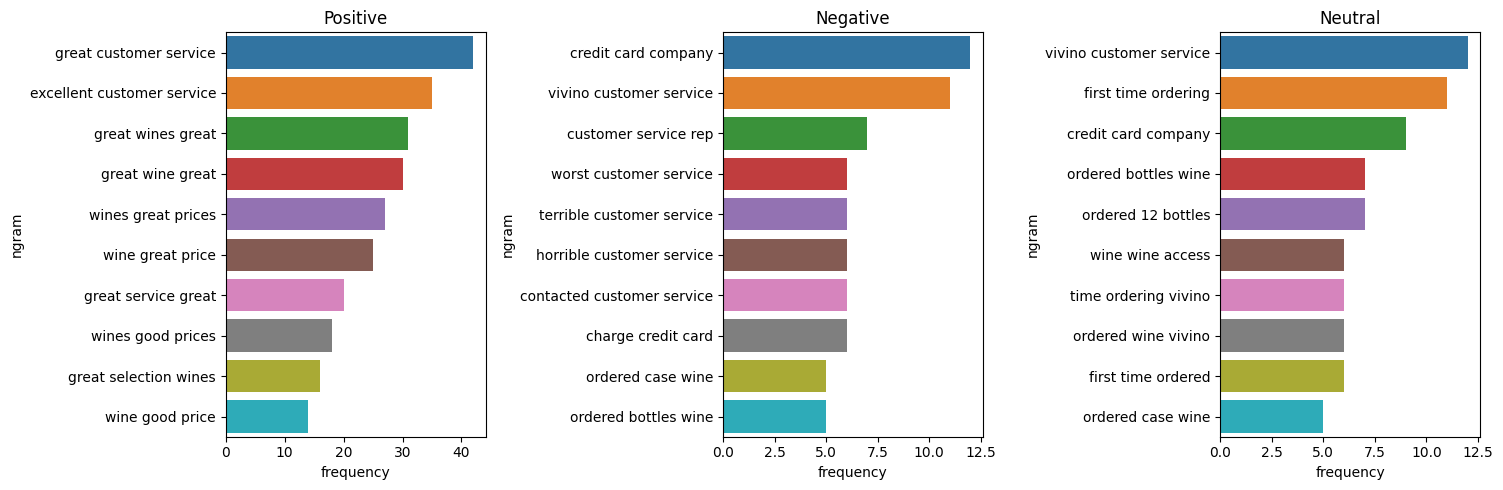

In [63]:
# Create a 1x3 grid of subplots for three bar plots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first bar plot in the first subplot (axes[0])
sns.barplot(x=ngram_freq_pos['frequency'][:10], y=ngram_freq_pos['ngram'][:10], ax=axes[0])
axes[0].set_title('Positive')

# Plot the second bar plot in the second subplot (axes[1])
sns.barplot(x=ngram_freq_neg['frequency'][:10], y=ngram_freq_neg['ngram'][:10], ax=axes[1])
axes[1].set_title('Negative')

# Plot the third bar plot in the third subplot (axes[2])
sns.barplot(x=ngram_freq_neu['frequency'][:10], y=ngram_freq_neu['ngram'][:10], ax=axes[2])
axes[2].set_title('Neutral')

# Adjust spacing between subplots if needed
plt.tight_layout()

# Display the plot
plt.show()